In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import json
import nltk
import unicodedata
import re
import string
import joblib as joblib
import pickle as pickle

In [2]:
# Load data
data_train = pd.read_csv('../Dataset/train_data.csv')
data_test = pd.read_csv('../Dataset/test_data.csv')

In [3]:
X_train = data_train['article']
y_train = data_train['label']

X_test = data_test['article']
y_test = data_test['label']

In [4]:
# Text preprocessing
def wordopt(text):
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W", " ", text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

ps = PorterStemmer()
with open('../Resources/stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)

def preprocess(text):
    text = wordopt(text)
    tokens = nltk.word_tokenize(text)
    stems = [ps.stem(token) for token in tokens]
    filtered = [stem for stem in stems if stem not in stopwords]
    return filtered

In [5]:
# Apply preprocess function to X_train
X_train = X_train.apply(preprocess)

# Apply preprocess function to X_test
X_test = X_test.apply(preprocess)

In [6]:
# Convert the preprocessed text into a list of strings
X_train_processed = [' '.join(tokens) for tokens in X_train]
X_test_processed = [' '.join(tokens) for tokens in X_test]

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_processed)

# Transform the validation data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test_processed)

# Print the shape of the TF-IDF matrices (No of rows, No of columns)
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)

Shape of X_train_tfidf: (2103, 27707)
Shape of X_test_tfidf: (902, 27707)


In [7]:
# Initializing base models

mnb = MultinomialNB(alpha= 0.1, fit_prior=False)
lr = LogisticRegression(C= 100, penalty= 'l2', solver= 'liblinear')
rf = RandomForestClassifier(n_estimators= 300, random_state=42)
knn = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 5, weights= 'uniform')
svm = SVC(C=10, degree=2, kernel = 'linear', probability = True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']

In [8]:
# Define the MLP as meta learner
mlp = MLPClassifier()

In [56]:
best_meta = MLPClassifier(
    activation = 'tanh', 
    hidden_layer_sizes = (10,), 
    learning_rate = 'constant', 
    solver = 'adam', # adam
    max_iter = 300,
    alpha = 0.01,)

In [66]:
# Save the lr_grid using joblib
joblib.dump(best_meta, '../Models/Grid/grid_mlp_3.joblib')

['../Models/Grid/grid_mlp_3.joblib']

In [57]:
# Create StackingClassifier
stack = StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=best_meta, cv=5)

# Fit StackingClassifier
stack.fit(X_train_tfidf, y_train)

StackingClassifier(cv=5,
                   estimators=[('MNB',
                                MultinomialNB(alpha=0.1, fit_prior=False)),
                               ('LR',
                                LogisticRegression(C=100, solver='liblinear')),
                               ('RF',
                                RandomForestClassifier(n_estimators=300,
                                                       random_state=42)),
                               ('KNN',
                                KNeighborsClassifier(metric='euclidean')),
                               ('SVM',
                                SVC(C=10, degree=2, kernel='linear',
                                    probability=True))],
                   final_estimator=MLPClassifier(activation='tanh', alpha=0.01,
                                                 hidden_layer_sizes=(10,),
                                                 max_iter=300))

PERFORMANCE EVALUATION: TRAINING

MNB:
  Accuracy: 0.9933
  Precision: 0.9915
  Recall: 0.9953
  F1-score: 0.9934
  ROC AUC: 0.9933
  Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1047
           1       0.99      1.00      0.99      1056

    accuracy                           0.99      2103
   macro avg       0.99      0.99      0.99      2103
weighted avg       0.99      0.99      0.99      2103

LR:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
  ROC AUC: 1.0000
  Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1047
           1       1.00      1.00      1.00      1056

    accuracy                           1.00      2103
   macro avg       1.00      1.00      1.00      2103
weighted avg       1.00      1.00      1.00      2103

RF:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
  ROC AUC: 1.0000
  Cl

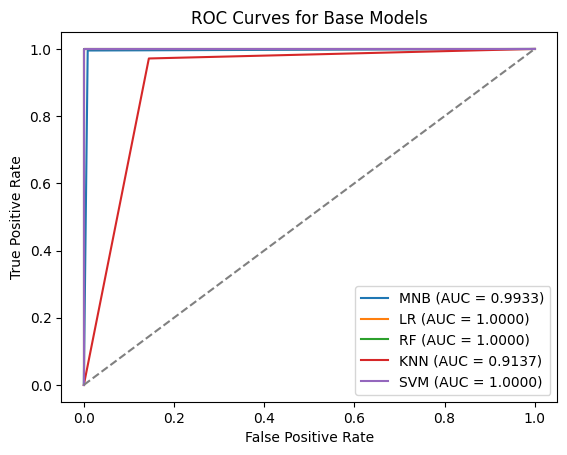

In [58]:
# Create an empty DataFrame for storing metrics
metrics_df_train = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Access trained base models
trained_base_models = {name: model for name, model in stack.named_estimators_.items()}

# Initialize lists to store ROC curve data
plt.figure()

# Evaluate each trained base model
for name, model in trained_base_models.items():
    y_pred = model.predict(X_train_tfidf)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    roc_auc = roc_auc_score(y_train, y_pred)
    
    # Print evaluation metrics
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    
    # Store metrics in the DataFrame
    metrics_df_train.loc[name] = [accuracy, precision, recall, f1, roc_auc]
    
    # Print classification report
    print(f"  Classification Report:")
    print(classification_report(y_train, y_pred))
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_train, y_pred)

    # Plot ROC curve for each model
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

# Plot ROC curve for random guessing (baseline)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Base Models')
plt.legend()
plt.show()

Metrics for Stacking Model:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1047
           1       1.00      1.00      1.00      1056

    accuracy                           1.00      2103
   macro avg       1.00      1.00      1.00      2103
weighted avg       1.00      1.00      1.00      2103



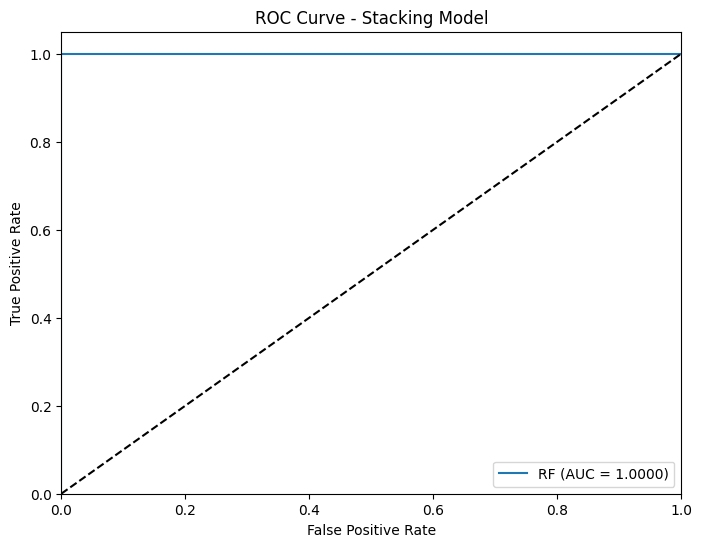

In [59]:
# Evaluate stacking model on training data
stack_y_pred_train = stack.predict(X_train_tfidf)
stack_y_prob_train = stack.predict_proba(X_train_tfidf)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy_train = accuracy_score(y_train, stack_y_pred_train)
stack_precision_train = precision_score(y_train, stack_y_pred_train)
stack_recall_train = recall_score(y_train, stack_y_pred_train)
stack_f1_train = f1_score(y_train, stack_y_pred_train)
stack_auc_train = roc_auc_score(y_train, stack_y_prob_train)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy_train:.4f}")
print(f"Precision: {stack_precision_train:.4f}")
print(f"Recall: {stack_recall_train:.4f}")
print(f"F1 Score: {stack_f1_train:.4f}")
print(f"AUC: {stack_auc_train:.4f}")
print(f"Classification Report:\n{classification_report(y_train, stack_y_pred_train)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_train, stack_y_prob_train)
stack_roc_auc = roc_auc_score(y_train, stack_y_prob_train)

# Store stacking model metrics in the DataFrame
metrics_df_train.loc['Stacking Model'] = [stack_accuracy_train, stack_precision_train, stack_recall_train, stack_f1_train, stack_auc_train]

# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'RF (AUC = {stack_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

In [60]:
# Display the comparison table
print("Comparison of Models:")
print(metrics_df_train)

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB             0.993343  0.991509  0.995265  0.993384  0.993335
LR                   1.0       1.0       1.0       1.0       1.0
RF                   1.0       1.0       1.0       1.0       1.0
KNN             0.913932  0.871708  0.971591  0.918943  0.913685
SVM                  1.0       1.0       1.0       1.0       1.0
Stacking Model       1.0       1.0       1.0       1.0       1.0


PERFORMANCE EVALUATION: TESTING

MNB:
  Accuracy: 0.9024
  Precision: 0.8732
  Recall: 0.9426
  F1-score: 0.9066
  ROC AUC: 0.9023
  Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       449
           1       0.87      0.94      0.91       453

    accuracy                           0.90       902
   macro avg       0.91      0.90      0.90       902
weighted avg       0.90      0.90      0.90       902

LR:
  Accuracy: 0.9390
  Precision: 0.9482
  Recall: 0.9294
  F1-score: 0.9387
  ROC AUC: 0.9391
  Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       449
           1       0.95      0.93      0.94       453

    accuracy                           0.94       902
   macro avg       0.94      0.94      0.94       902
weighted avg       0.94      0.94      0.94       902

RF:
  Accuracy: 0.9279
  Precision: 0.9350
  Recall: 0.9205
  F1-score: 0.9277
  ROC AUC: 0.9280
  Cl

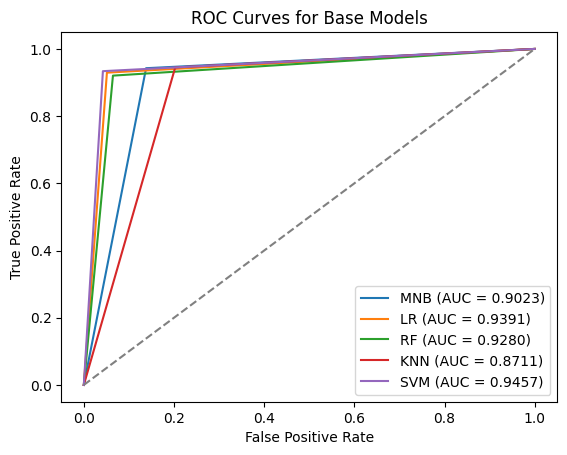

In [61]:
# Create an empty DataFrame for storing metrics
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Access trained base models
trained_base_models = {name: model for name, model in stack.named_estimators_.items()}

# Initialize lists to store ROC curve data
plt.figure()

# Evaluate each trained base model
for name, model in trained_base_models.items():
    y_pred = model.predict(X_test_tfidf)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Print evaluation metrics
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    
    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, roc_auc]
    
    # Print classification report
    print(f"  Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    # Plot ROC curve for each model
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

# Plot ROC curve for random guessing (baseline)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Base Models')
plt.legend()
plt.show()

Metrics for Stacking Model:
Accuracy: 0.9512
Precision: 0.9495
Recall: 0.9536
F1 Score: 0.9515418502202643:.4f
AUC: 0.9882
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       449
           1       0.95      0.95      0.95       453

    accuracy                           0.95       902
   macro avg       0.95      0.95      0.95       902
weighted avg       0.95      0.95      0.95       902



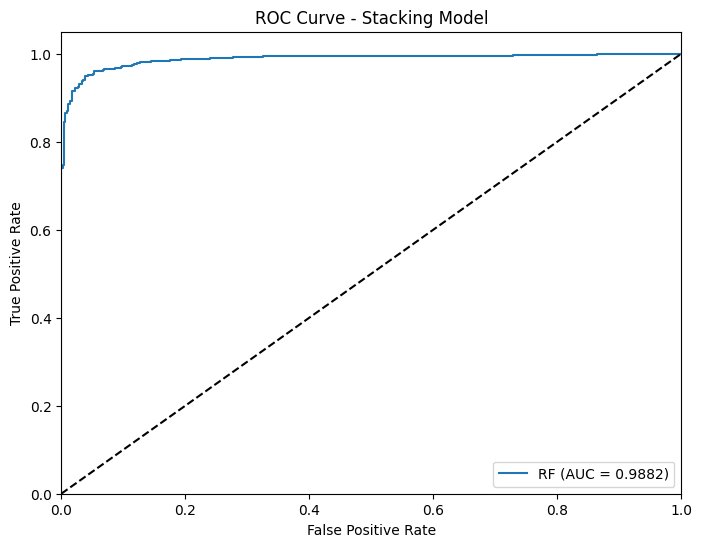

In [62]:
# Evaluate stacking model
stack_y_pred = stack.predict(X_test_tfidf)
stack_y_prob = stack.predict_proba(X_test_tfidf)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(y_test, stack_y_pred)
stack_precision = precision_score(y_test, stack_y_pred)
stack_recall = recall_score(y_test, stack_y_pred)
stack_f1 = f1_score(y_test, stack_y_pred)
stack_auc = roc_auc_score(y_test, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy:.4f}")
print(f"Precision: {stack_precision:.4f}")
print(f"Recall: {stack_recall:.4f}")
print(f"F1 Score: {stack_f1}:.4f")
print(f"AUC: {stack_auc:.4f}")
print(f"Classification Report:\n{classification_report(y_test, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_test, stack_y_prob)
stack_roc_auc = roc_auc_score(y_test, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'RF (AUC = {stack_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

In [63]:
# Display the comparison table
print("Comparison of Models:")
print(metrics_df)

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB             0.902439  0.873211  0.942605  0.906582   0.90226
LR              0.939024  0.948198   0.92936  0.938685  0.939067
RF              0.927938  0.934978   0.92053  0.927697  0.927971
KNN             0.871397  0.824663  0.944812  0.880658   0.87107
SVM             0.945676  0.957014  0.933775  0.945251  0.945729
Stacking Model   0.95122  0.949451  0.953642  0.951542  0.988225


In [65]:
# Save the model using joblib
joblib.dump(stack, '../Models/Stack/stack_mlp_3.joblib')

['../Models/Stack/stack_mlp_3.joblib']

In [68]:
print(stack)

StackingClassifier(cv=5,
                   estimators=[('MNB',
                                MultinomialNB(alpha=0.1, fit_prior=False)),
                               ('LR',
                                LogisticRegression(C=100, solver='liblinear')),
                               ('RF',
                                RandomForestClassifier(n_estimators=300,
                                                       random_state=42)),
                               ('KNN',
                                KNeighborsClassifier(metric='euclidean')),
                               ('SVM',
                                SVC(C=10, degree=2, kernel='linear',
                                    probability=True))],
                   final_estimator=MLPClassifier(activation='tanh', alpha=0.01,
                                                 hidden_layer_sizes=(10,),
                                                 max_iter=300))
